# **Credit Card Fraud Detection**
- 링크
> https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
- 데이터셋 개요
> 이 데이터세트는 2013년 9월 유럽 카드 소지자들의 신용카드 거래 내역을 담고 있습니다.
이 데이터세트는 이틀 동안 발생한 거래를 보여주며, 총 284,807건의 거래 중 492건이 사기로 확인되었습니다. 이 데이터세트는 매우 불균형하며, 양성 클래스(사기)는 전체 거래의 0.172%를 차지합니다.
- V1, V2, .. V28: PCA를 통해 얻은 주성분
- Amount: 거래 금액
- Time: 특성 '시간'은 각 거래와 데이터 세트의 첫 번째 거래 사이에 경과된 시간(초)을 포함 (시간 변환 시 48시간까지 존재. 즉, 이틀 간 거래 정보에 대한 데이터임.)
- 성능평가: AUPRC 사용하여 정확도 측정

- 목표: f1스코어를 높이되, 실제 class=1인 경우 모델이 class=0이라고 분류했을 경우 risk가 훨씬 크므로 precision을 최대한 높이는 것을 목표로 한다.



# 0. 라이브러리

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score

# 1. 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터셋 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기계학습/creditcard.csv')

In [ ]:
display(df.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# 원본 데이터셋 train/ test로 분리
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])

# 분리 결과 확인
print("Train class distribution:\n", train['Class'].value_counts(normalize=True))
print('Train shape: ', train.shape)
print('----------------------------------')
print("Test  class distribution:\n", test['Class'].value_counts(normalize=True))
print('Test shape', test.shape)

Train class distribution:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Train shape:  (227845, 31)
----------------------------------
Test  class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64
Test shape (56962, 31)


In [ ]:
print(train.shape)
print(test.shape)

(227845, 31)
(56962, 31)


In [ ]:
# 데이터 확인
display(train.head())
display(train.shape)
display(train.columns)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
265518,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,...,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.32,0
180305,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,...,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.99,0
42664,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,...,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.10,0
198723,132624.0,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,...,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.10,0
82325,59359.0,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,...,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.10,0


(227845, 31)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
265518,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,...,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.32,0
180305,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,...,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.99,0
42664,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,...,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.10,0
198723,132624.0,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,...,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.10,0
82325,59359.0,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,...,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233802,147710.0,1.993864,-0.516866,-0.620118,0.129845,-0.285128,0.395044,-0.822358,0.231591,0.995898,...,0.262526,0.884510,0.099141,0.275689,-0.195404,0.623598,-0.032455,-0.058552,5.99,0
85418,60764.0,-1.497933,0.657921,1.581568,-0.024286,0.584698,1.303031,0.609212,0.135561,0.452745,...,-0.072452,0.299172,0.110048,-0.615980,-0.425883,0.263968,-0.448445,0.045178,36.99,0
29062,35301.0,1.069777,0.072105,0.496540,1.505318,-0.380277,-0.370243,0.100551,-0.026687,0.319684,...,-0.061991,-0.044629,-0.050485,0.400171,0.593314,-0.335160,0.031014,0.024886,45.42,0
13766,24413.0,1.280465,0.300586,0.333044,0.512720,0.065052,-0.145844,-0.145519,-0.091833,1.111187,...,-0.409934,-0.961351,0.033153,-0.560429,0.278428,0.089546,-0.059835,-0.005887,0.89,0


In [ ]:
test

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
263020,160760.0,-0.674466,1.408105,-1.110622,-1.328366,1.388996,-1.308439,1.885879,-0.614233,0.311652,...,0.080084,0.810034,-0.224327,0.707899,-0.135837,0.045102,0.533837,0.291319,23.00,0
11378,19847.0,-2.829816,-2.765149,2.537793,-1.074580,2.842559,-2.153536,-1.795519,-0.250020,3.073504,...,-0.295555,0.109305,-0.813272,0.042996,-0.027660,-0.910247,0.110802,-0.511938,11.85,0
147283,88326.0,-3.576495,2.318422,1.306985,3.263665,1.127818,2.865246,1.444125,-0.718922,1.874046,...,-1.060151,0.016867,-0.132058,-1.483996,-0.296011,0.062823,0.552411,0.509764,76.07,0
219439,141734.0,2.060386,-0.015382,-1.082544,0.386019,-0.024331,-1.074935,0.207792,-0.338140,0.455091,...,-0.281684,-0.639426,0.331818,-0.067584,-0.283675,0.203529,-0.063621,-0.060077,0.99,0
36939,38741.0,1.209965,1.384303,-1.343531,1.763636,0.662351,-2.113384,0.854039,-0.475963,-0.629658,...,-0.164015,-0.328294,-0.154631,0.619449,0.818998,-0.330525,0.046884,0.104527,1.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54199,46329.0,-0.863057,0.225429,2.458855,0.613099,0.067149,1.716173,-0.254484,0.825754,0.407484,...,0.183183,0.695818,0.101555,-0.683590,-0.505613,-0.343860,0.218972,0.127074,35.97,0
184616,126310.0,1.397799,-1.426153,-0.369131,0.891825,-1.164153,-0.166657,-0.320745,-0.023070,1.800818,...,-0.058383,-0.479606,0.053303,-0.117313,-0.425722,-0.568239,0.001064,0.017812,297.63,0
274532,166070.0,-1.047727,0.685141,0.195457,-3.583402,0.082922,-0.444060,0.261275,0.457403,1.225167,...,-0.120079,-0.388817,-0.095996,-1.059673,-0.392663,-0.781760,0.017347,0.145133,16.39,0
269819,163789.0,2.159972,-1.084234,-0.858819,-1.126188,-0.647032,0.234289,-1.164932,0.138244,-0.045273,...,0.327882,0.932738,0.077597,0.119508,-0.090098,-0.101767,-0.002565,-0.056766,19.95,0


#2. 베이스라인 모델
- 전처리 전 먼저 모델 학습 진행

In [ ]:
X_train = train.drop('Class', axis=1)
y_train = train['Class']
X_test = test.drop('Class', axis=1)
y_test = test['Class']

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.69      0.73      0.71        98

    accuracy                           1.00     56962
   macro avg       0.85      0.87      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 
 [[56832    32]
 [   26    72]]
AUPRC (Area Under PR Curve): 0.6125


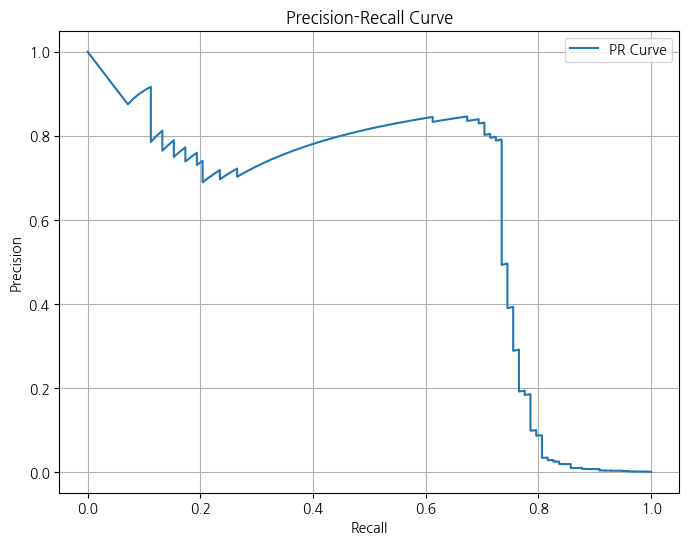

In [ ]:
# 로지스틱 회귀
lr = LogisticRegression()
lr.fit(X_train, y_train)

# 예측 및 평가
y_pred = lr.predict(X_test)
y_scores = lr.predict_proba(X_test)[:, 1] # Class=1 일 확률만 추출

# 정밀도-재현율 곡선(PR) 계산
precision, recall, _ = precision_recall_curve(y_test, y_scores)
# AURPRC 계산
auc_rc = auc(recall, precision)

print('Classfication Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('AUPRC (Area Under PR Curve):', round(auc_rc, 4))

# PR 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.79      0.81        98

    accuracy                           1.00     56962
   macro avg       0.92      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 
 [[56850    14]
 [   21    77]]
AUPRC (Area Under PR Curve): 0.8225


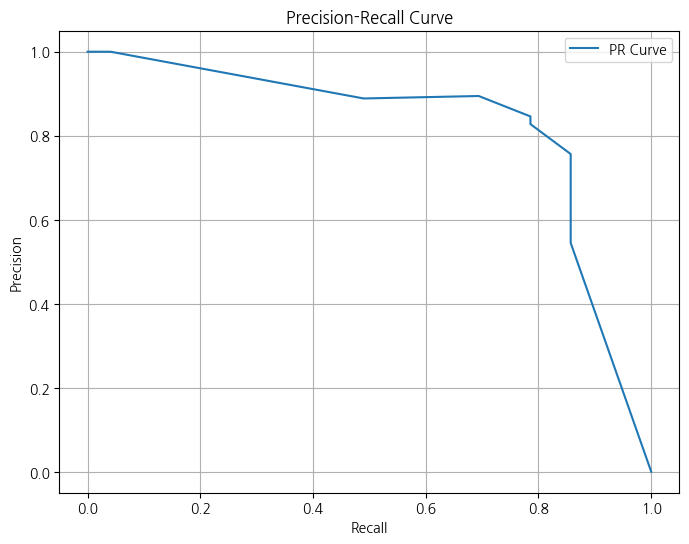

In [ ]:
# DecisonTree - Gini
dt = DecisionTreeClassifier(criterion='gini',random_state=42, max_depth=4)
dt.fit(X_train, y_train)

# 예측 및 평가
y_pred = dt.predict(X_test)
y_scores = dt.predict_proba(X_test)[:, 1] # Class=1 일 확률만 추출

# 정밀도-재현율 곡선(PR) 계산
precision, recall, _ = precision_recall_curve(y_test, y_scores)
# AURPRC 계산
auc_rc = auc(recall, precision)

print('Classfication Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('AUPRC (Area Under PR Curve):', round(auc_rc, 4))

# PR 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.83        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 
 [[56848    16]
 [   17    81]]
AUPRC (Area Under PR Curve): 0.6705


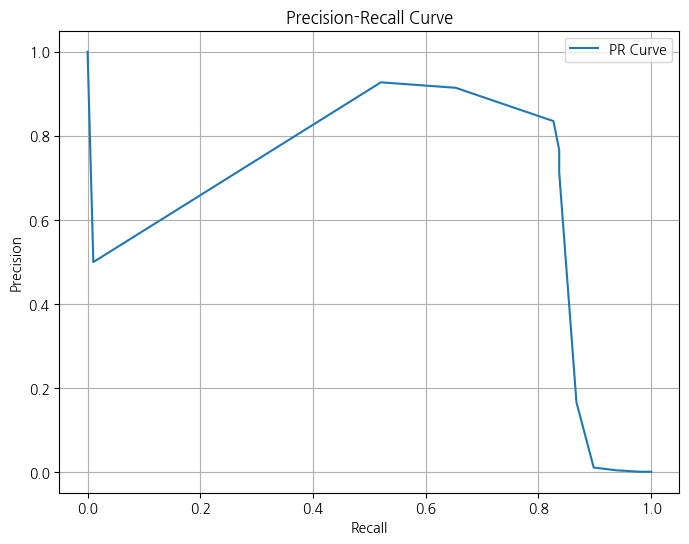

In [ ]:
# DecisonTree - Entropy
dt = DecisionTreeClassifier(criterion='entropy',random_state=42, max_depth=4)
dt.fit(X_train, y_train)

# 예측 및 평가
y_pred = dt.predict(X_test)
y_scores = dt.predict_proba(X_test)[:, 1] # Class=1 일 확률만 추출

# 정밀도-재현율 곡선(PR) 계산
precision, recall, _ = precision_recall_curve(y_test, y_scores)
# AURPRC 계산
auc_rc = auc(recall, precision)

print('Classfication Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('AUPRC (Area Under PR Curve):', round(auc_rc, 4))

# PR 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

- 분할 조건이 지니 계수일 때가 성능이 더 좋음 -> 아마 클래스의 대부분이 정상 거래이므로 분할 조건이 지니계수일 때가 더 정확도가 높게 나타났을 것

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.03      0.06        98

    accuracy                           1.00     56962
   macro avg       1.00      0.52      0.53     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 
 [[56864     0]
 [   95     3]]
AUPRC (Area Under PR Curve): 0.2299


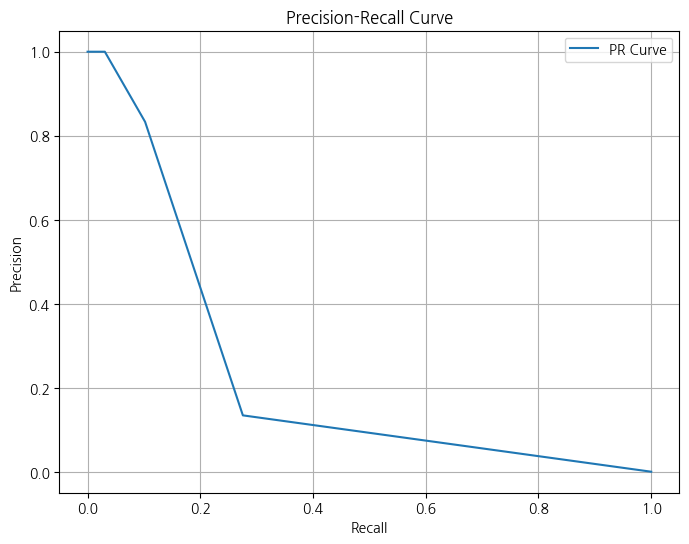

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train, y_train)

# 예측 및 평가
y_pred = knn.predict(X_test)
y_scores = knn.predict_proba(X_test)[:, 1] # Class=1 일 확률만 추출

# 정밀도-재현율 곡선(PR) 계산
precision, recall, _ = precision_recall_curve(y_test, y_scores)
# AURPRC 계산
auc_rc = auc(recall, precision)

print('Classfication Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('AUPRC (Area Under PR Curve):', round(auc_rc, 4))

# PR 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

- 변수들 간 스케일링이 되어있지 않기 때문에 KNN 성능이 낮게 나타난 것으로 추측됨

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.52      0.26      0.34        98

    accuracy                           1.00     56962
   macro avg       0.76      0.63      0.67     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 
 [[56841    23]
 [   73    25]]
AUPRC (Area Under PR Curve): 0.2228


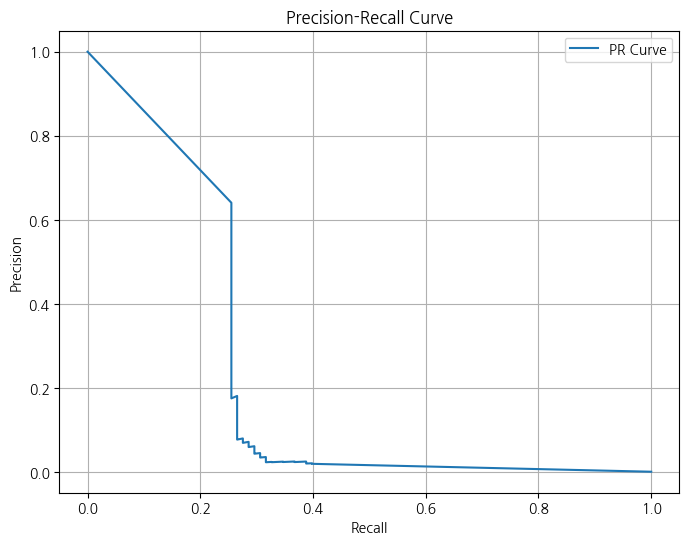

In [ ]:
# MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),   # 은닉층 구조: 예시로 히든 노드 100개짜리 한 층
    activation='relu',           # 활성화 함수 (ReLU)
    solver='adam',               # 최적화 알고리즘 (Adam)
    alpha=0.0001,                # L2 정규화 (weight_decay)
    learning_rate='adaptive',    # 학습률 조정 방식
    max_iter=200,                # 최대 반복(epoch) 수
    random_state=42
)
mlp.fit(X_train, y_train)

# 예측 및 평가
y_pred = mlp.predict(X_test)
y_scores = mlp.predict_proba(X_test)[:, 1] # Class=1 일 확률만 추출

# 정밀도-재현율 곡선(PR) 계산
precision, recall, _ = precision_recall_curve(y_test, y_scores)
# AURPRC 계산
auc_rc = auc(recall, precision)

print('Classfication Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('AUPRC (Area Under PR Curve):', round(auc_rc, 4))

# PR 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix: 
 [[56859     5]
 [   17    81]]
AUPRC (Area Under PR Curve): 0.8582


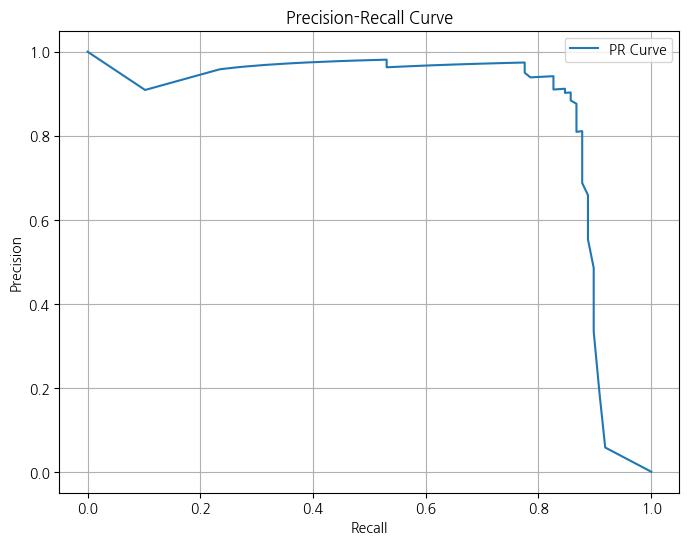

In [ ]:
# RandomForest
rf = RandomForestClassifier(random_state=3, n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

# 예측 및 평가
y_pred = rf.predict(X_test)
y_scores = rf.predict_proba(X_test)[:, 1] # Class=1 일 확률만 추출

# 정밀도-재현율 곡선(PR) 계산
precision, recall, _ = precision_recall_curve(y_test, y_scores)
# AURPRC 계산
auc_rc = auc(recall, precision)

print('Classfication Report: \n', classification_report(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('AUPRC (Area Under PR Curve):', round(auc_rc, 4))

# PR 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

- 랜덤포레스트가 가장 우수한 성능을 보임
- 불균형 데이터이므로 정확도는 무의미함
- Precision: 0.94 -> 사기라고 예측한 것들 중 94%가 실제 사기거래
- Recall: 0.83 -> 전체 사기거래 중 83% 잡아냄
- F1-score: 0.88 -> 모델의 전반적인 분류 능력 우수
- AUPRC: 0.86: 불균형 문제를 잘 처리함

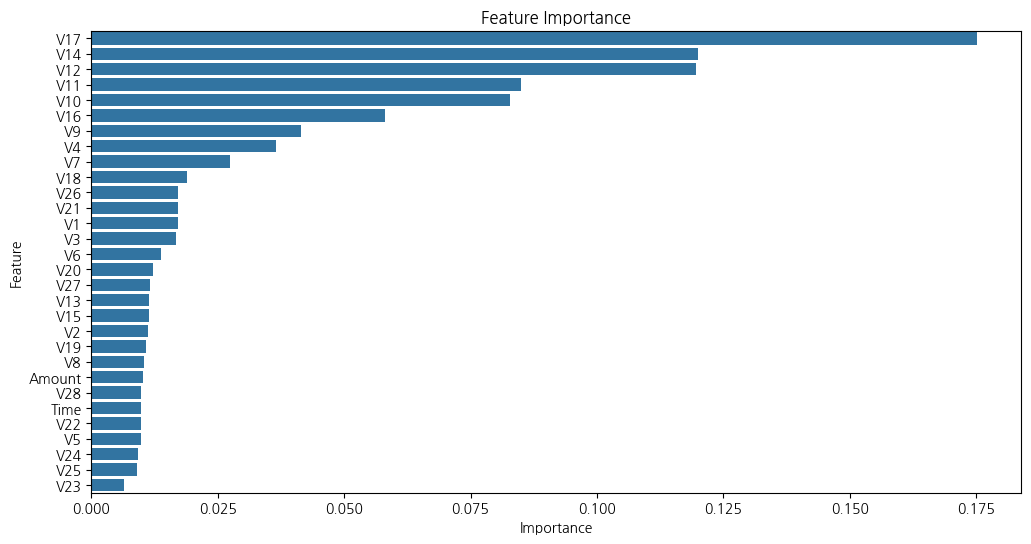

In [ ]:
# feature importance
feature_names = X_train.columns # 변수 이름 리스트
importances = rf.feature_importances_ # 중요도 추출

# 데이터 프레임으로 정렬
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # 내림차순 정렬

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance')
plt.show()

- 원본특성(Time, Amount)은 상대적으로 정보 기여도가 낮음 -> 제거하거나 스케일링 or 파생 변수 생성

# 3. EDA

In [ ]:
display(train.describe())
display(train.info())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,94885.093704,0.000795,-0.000481,-0.000383,-0.000020,0.000175,-0.001171,0.000077,-0.000434,0.000702,...,0.000370,0.000303,0.000050,-0.000277,-0.000655,0.000126,-0.000070,0.000154,88.176298,0.001729
std,47488.415034,1.958926,1.649092,1.515292,1.415867,1.379569,1.331218,1.238431,1.191482,1.097351,...,0.734963,0.725735,0.627419,0.605322,0.521236,0.481939,0.404934,0.326939,250.722602,0.041548
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54228.000000,-0.919893,-0.598761,-0.891767,-0.847111,-0.692100,-0.768603,-0.553481,-0.207839,-0.640307,...,-0.228250,-0.542056,-0.161932,-0.354843,-0.316907,-0.326491,-0.070740,-0.052931,5.640000,0.000000
50%,84805.000000,0.018692,0.064746,0.179859,-0.021361,-0.054757,-0.274156,0.040420,0.023219,-0.050653,...,-0.029280,0.006599,-0.010983,0.040778,0.016081,-0.051623,0.001463,0.011221,22.000000,0.000000
75%,139364.000000,1.315616,0.803876,1.026457,0.742281,0.611259,0.397501,0.570530,0.327824,0.598254,...,0.186365,0.528282,0.147589,0.438966,0.349880,0.240835,0.091180,0.078118,77.490000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,6.070850,3.517346,31.612198,33.847808,25691.160000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 227845 entries, 265518 to 17677
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    227845 non-null  float64
 1   V1      227845 non-null  float64
 2   V2      227845 non-null  float64
 3   V3      227845 non-null  float64
 4   V4      227845 non-null  float64
 5   V5      227845 non-null  float64
 6   V6      227845 non-null  float64
 7   V7      227845 non-null  float64
 8   V8      227845 non-null  float64
 9   V9      227845 non-null  float64
 10  V10     227845 non-null  float64
 11  V11     227845 non-null  float64
 12  V12     227845 non-null  float64
 13  V13     227845 non-null  float64
 14  V14     227845 non-null  float64
 15  V15     227845 non-null  float64
 16  V16     227845 non-null  float64
 17  V17     227845 non-null  float64
 18  V18     227845 non-null  float64
 19  V19     227845 non-null  float64
 20  V20     227845 non-null  float64
 21  V21     227

None

In [ ]:
# 결측치 확인
total_cells = train.shape[0] * train.shape[1]

# 결측치 총 개수
total_missing = train.isnull().sum().sum()

# 결측치 비율
missing_rate = total_missing / total_cells * 100 # % 단위
print(f"Missin Rate {missing_rate: .2f}%")

Missin Rate  0.00%


- 결측치 없음
- 정규화가 되어있진 않음

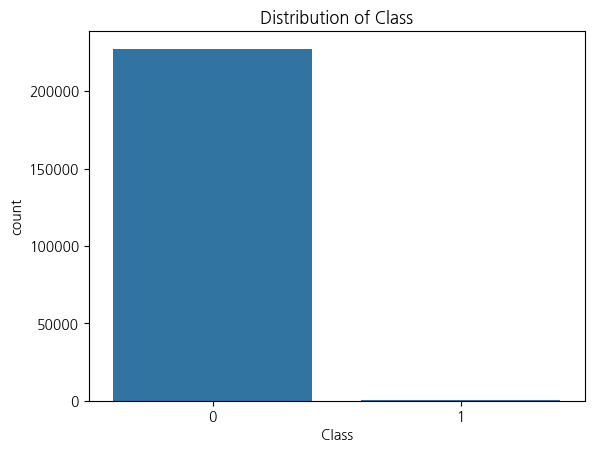

Class
0    227451
1       394
Name: count, dtype: int64


In [ ]:
# Class 분포 확인
sns.countplot(x='Class', data = train)
plt.title('Distribution of Class')
plt.savefig('class distribution.png')
plt.show()
print(train['Class'].value_counts())

- 클래스 분포가 매우 불균형함을 알 수 있음 -> 학습을 어떻게하여 class 예측 확률을 높일 것인가가 관건

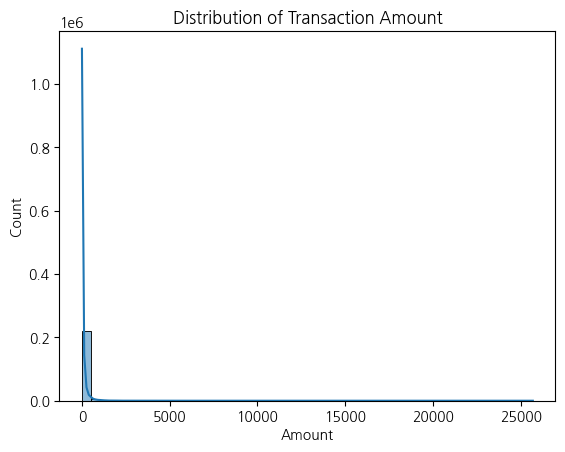

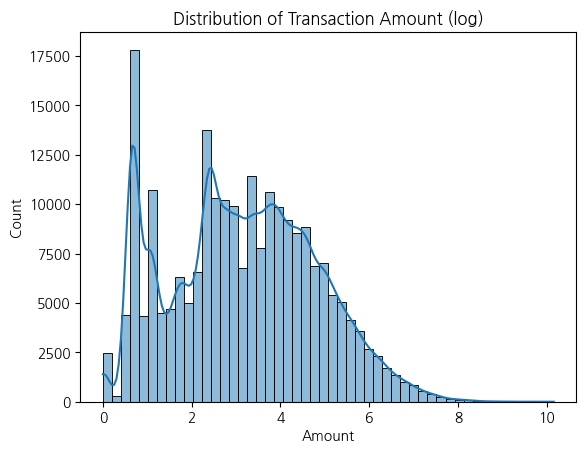

In [ ]:
# 거래 금액 분포
sns.histplot(train['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.show()

# 로그 변환 후 확인
sns.histplot(np.log1p(train['Amount']), bins=50, kde=True)
plt.title('Distribution of Transaction Amount (log)')
plt.show()

- 원본 거래금액량 분포
  - 불균형한 분포: 값이 한쪽으로 쏠려있음 -> 소액 결제가 대부분
  - 일부 거래는 1.5만~2.5만 이상
- 로그 변환 후 거래금액량 분포
  - 분포가 나름 정규분포에 가까워짐 -> 후에 스케일링

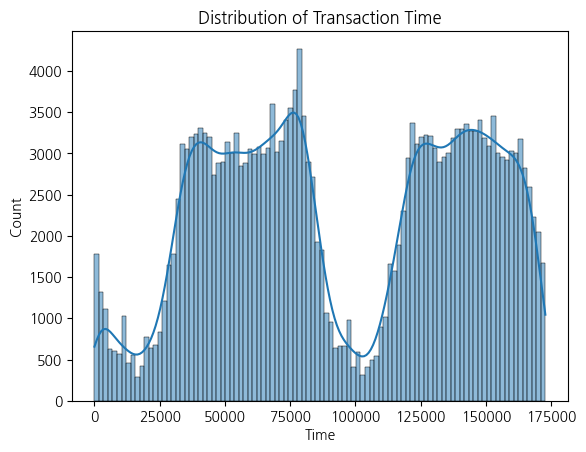

In [ ]:
# 시간 분포 확인: 첫 번째 거래 사이에 경과된 시간(초)
sns.histplot(train['Time'], bins=100, kde=True)
plt.title('Distribution of Transaction Time')
plt.savefig('Distribution of Transaction Time.png')
plt.show()

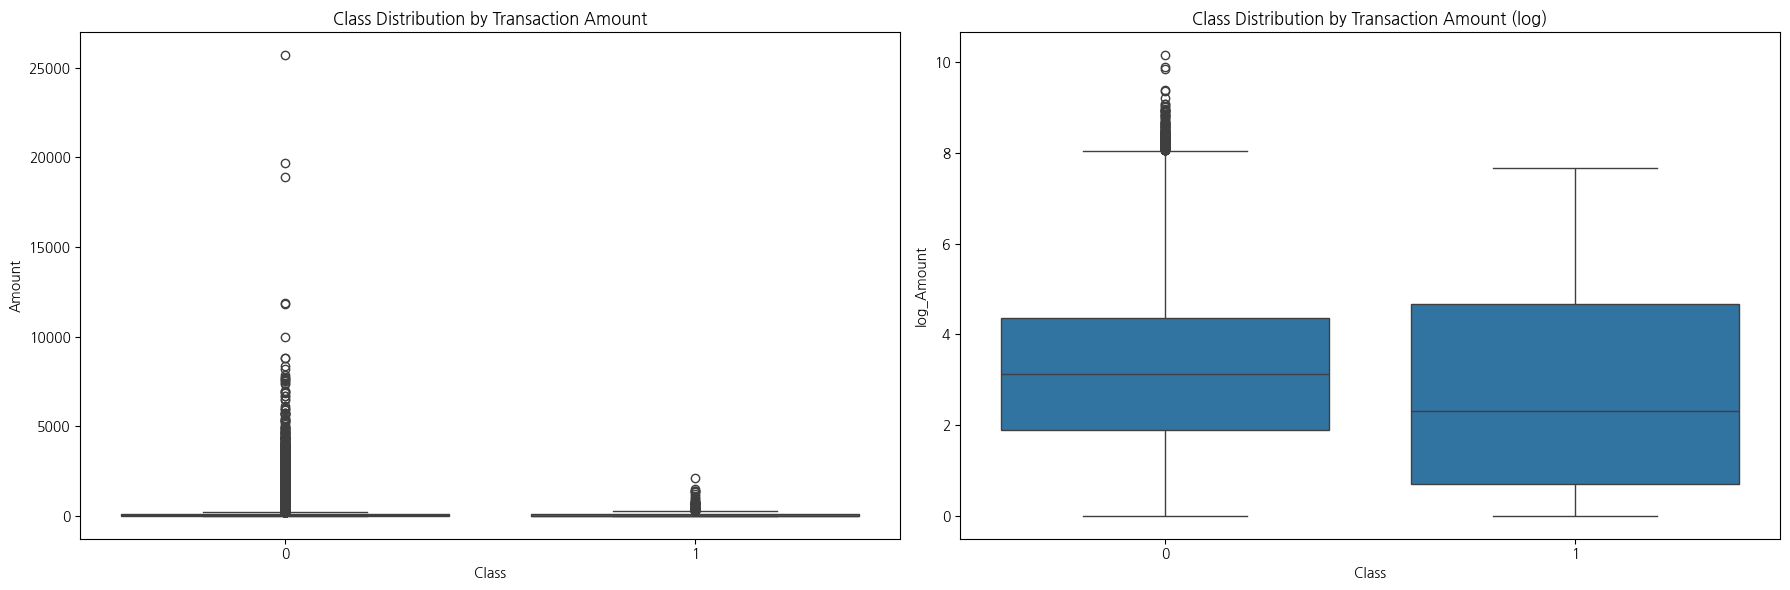

In [ ]:
# 거래량에 따른 클래스 분포 확인하기
# 로그 변환 칼럼 추가
train['log_Amount'] = np.log1p(train['Amount'])

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 로그 변환x로 확인
sns.boxplot(x='Class', y ='Amount', data=train, ax = axes[0])
axes[0].set_title('Class Distribution by Transaction Amount')

# 로그 변환o로 확인
sns.boxplot(x='Class', y='log_Amount', data=train, ax = axes[1])
axes[1].set_title('Class Distribution by Transaction Amount (log)')

plt.tight_layout()
plt.show()

- 정상거래의 경우 거래 금액의 분산이 매우크며, 25000 이상의 이상치도 있음
- 사기거래의 경우 거래 금액의 분산이 상대적으로 작고, 거래 금액 낮음. 대부분의 사기 거래가 낮은 금액에서 발생하는 것을 알 수 있음

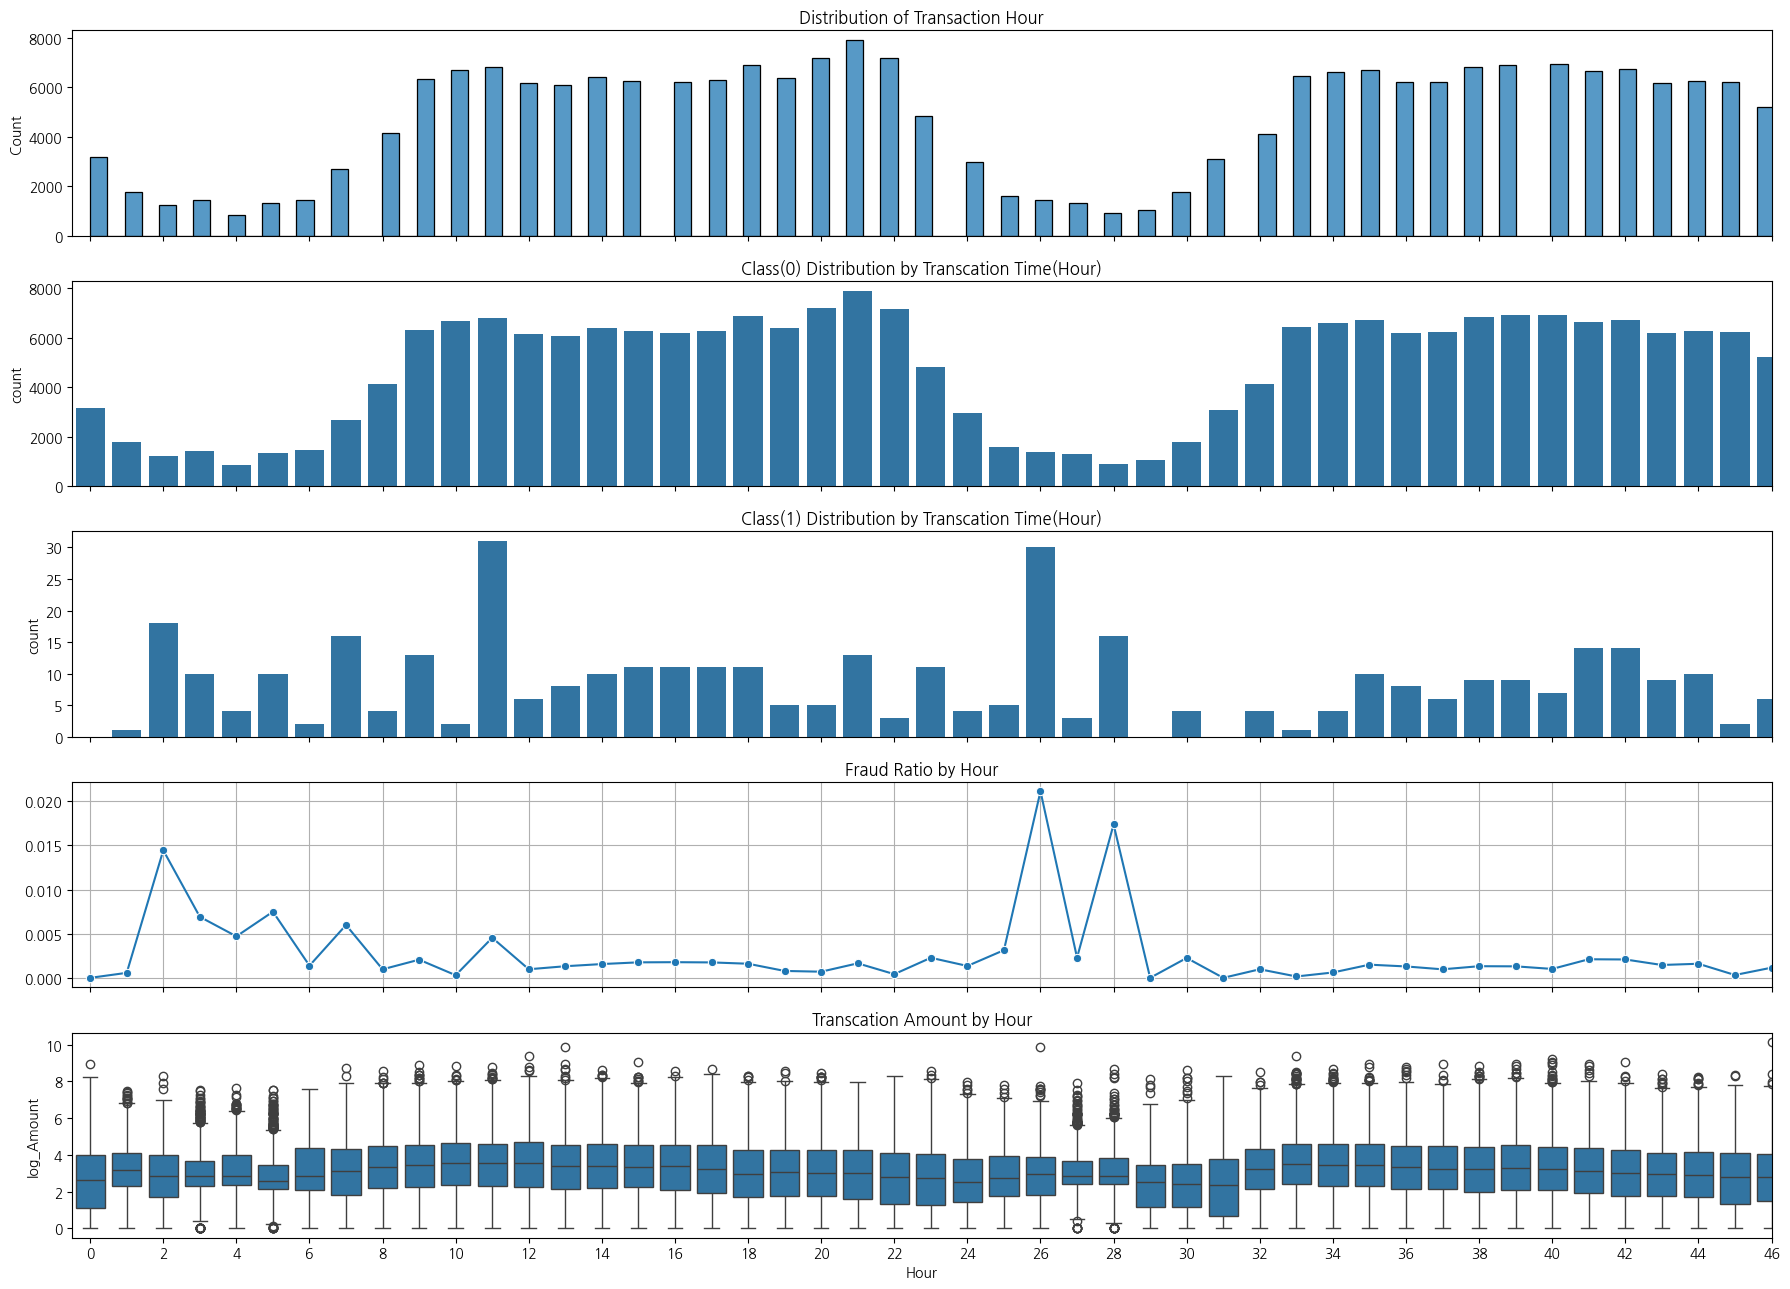

In [ ]:
# 시간대별 거래 수
# 시간 단위로 변환
train['Hour'] = (train['Time'] // 3600).astype(int)

fig, axes = plt.subplots(5, 1, figsize=(18, 13), sharex=True)

# 전체 거래 분포
sns.histplot(train['Hour'], bins=100, ax = axes[0])
axes[0].set_xticks(range(0, 48, 2))
axes[0].set_title('Distribution of Transaction Hour')

# 정상거래
sns.countplot(data = train[train['Class'] == 0], x='Hour', ax = axes[1])
axes[1].set_title('Class(0) Distribution by Transcation Time(Hour)')
axes[1].set_xticks(range(0, 48, 2))  # 2시간 간격
axes[1].tick_params(axis='x', rotation=45)

# 사기거래
sns.countplot(data = train[train['Class'] == 1], x='Hour', ax = axes[2])
axes[2].set_title('Class(1) Distribution by Transcation Time(Hour)')
axes[2].set_xticks(range(0, 48, 2))
axes[2].tick_params(axis='x', rotation=45)

# 시간대별 사기 비율
fraud_ratio = train.groupby('Hour')['Class'].mean()
sns.lineplot(x=fraud_ratio.index, y=fraud_ratio.values, marker='o', ax=axes[3])
axes[3].set_title('Fraud Ratio by Hour')
axes[3].grid(True)
axes[3].set_xticks(range(0, 48, 2))

# 시간대별 거래 금액
sns.boxplot(data = train, x='Hour', y='log_Amount', ax=axes[4])
axes[4].set_title('Transcation Amount by Hour')
axes[4].set_xticks(range(0, 48, 2))

plt.tight_layout()
plt.savefig('시간대별 거래 수.png')
plt.show()

- 사기 거래는 첫 거래 이후 대략 2시간, 10시간, 26시간 경과 시점에서 상대적으로 건수 자체가 많거나 비율이 높게 나타남
- 2시간대, 26시간대에서는 전체 거래 수는 많지 않음에도 사기율이 높게 나타남 -> 사기 탐지 시 민감하게 대응해야 할 시간대
- 10시간, 20시간, 42시간 등은 거래 비율이 높지만 사기 비율은 낮음 -> 정상 거래가 주도하는 시간대임
- 로그스케일 기준, 전체적으로 거래량은 고르게 분포함 -> 사기 여부와 거래량의 연관성은 잘 모르겠음

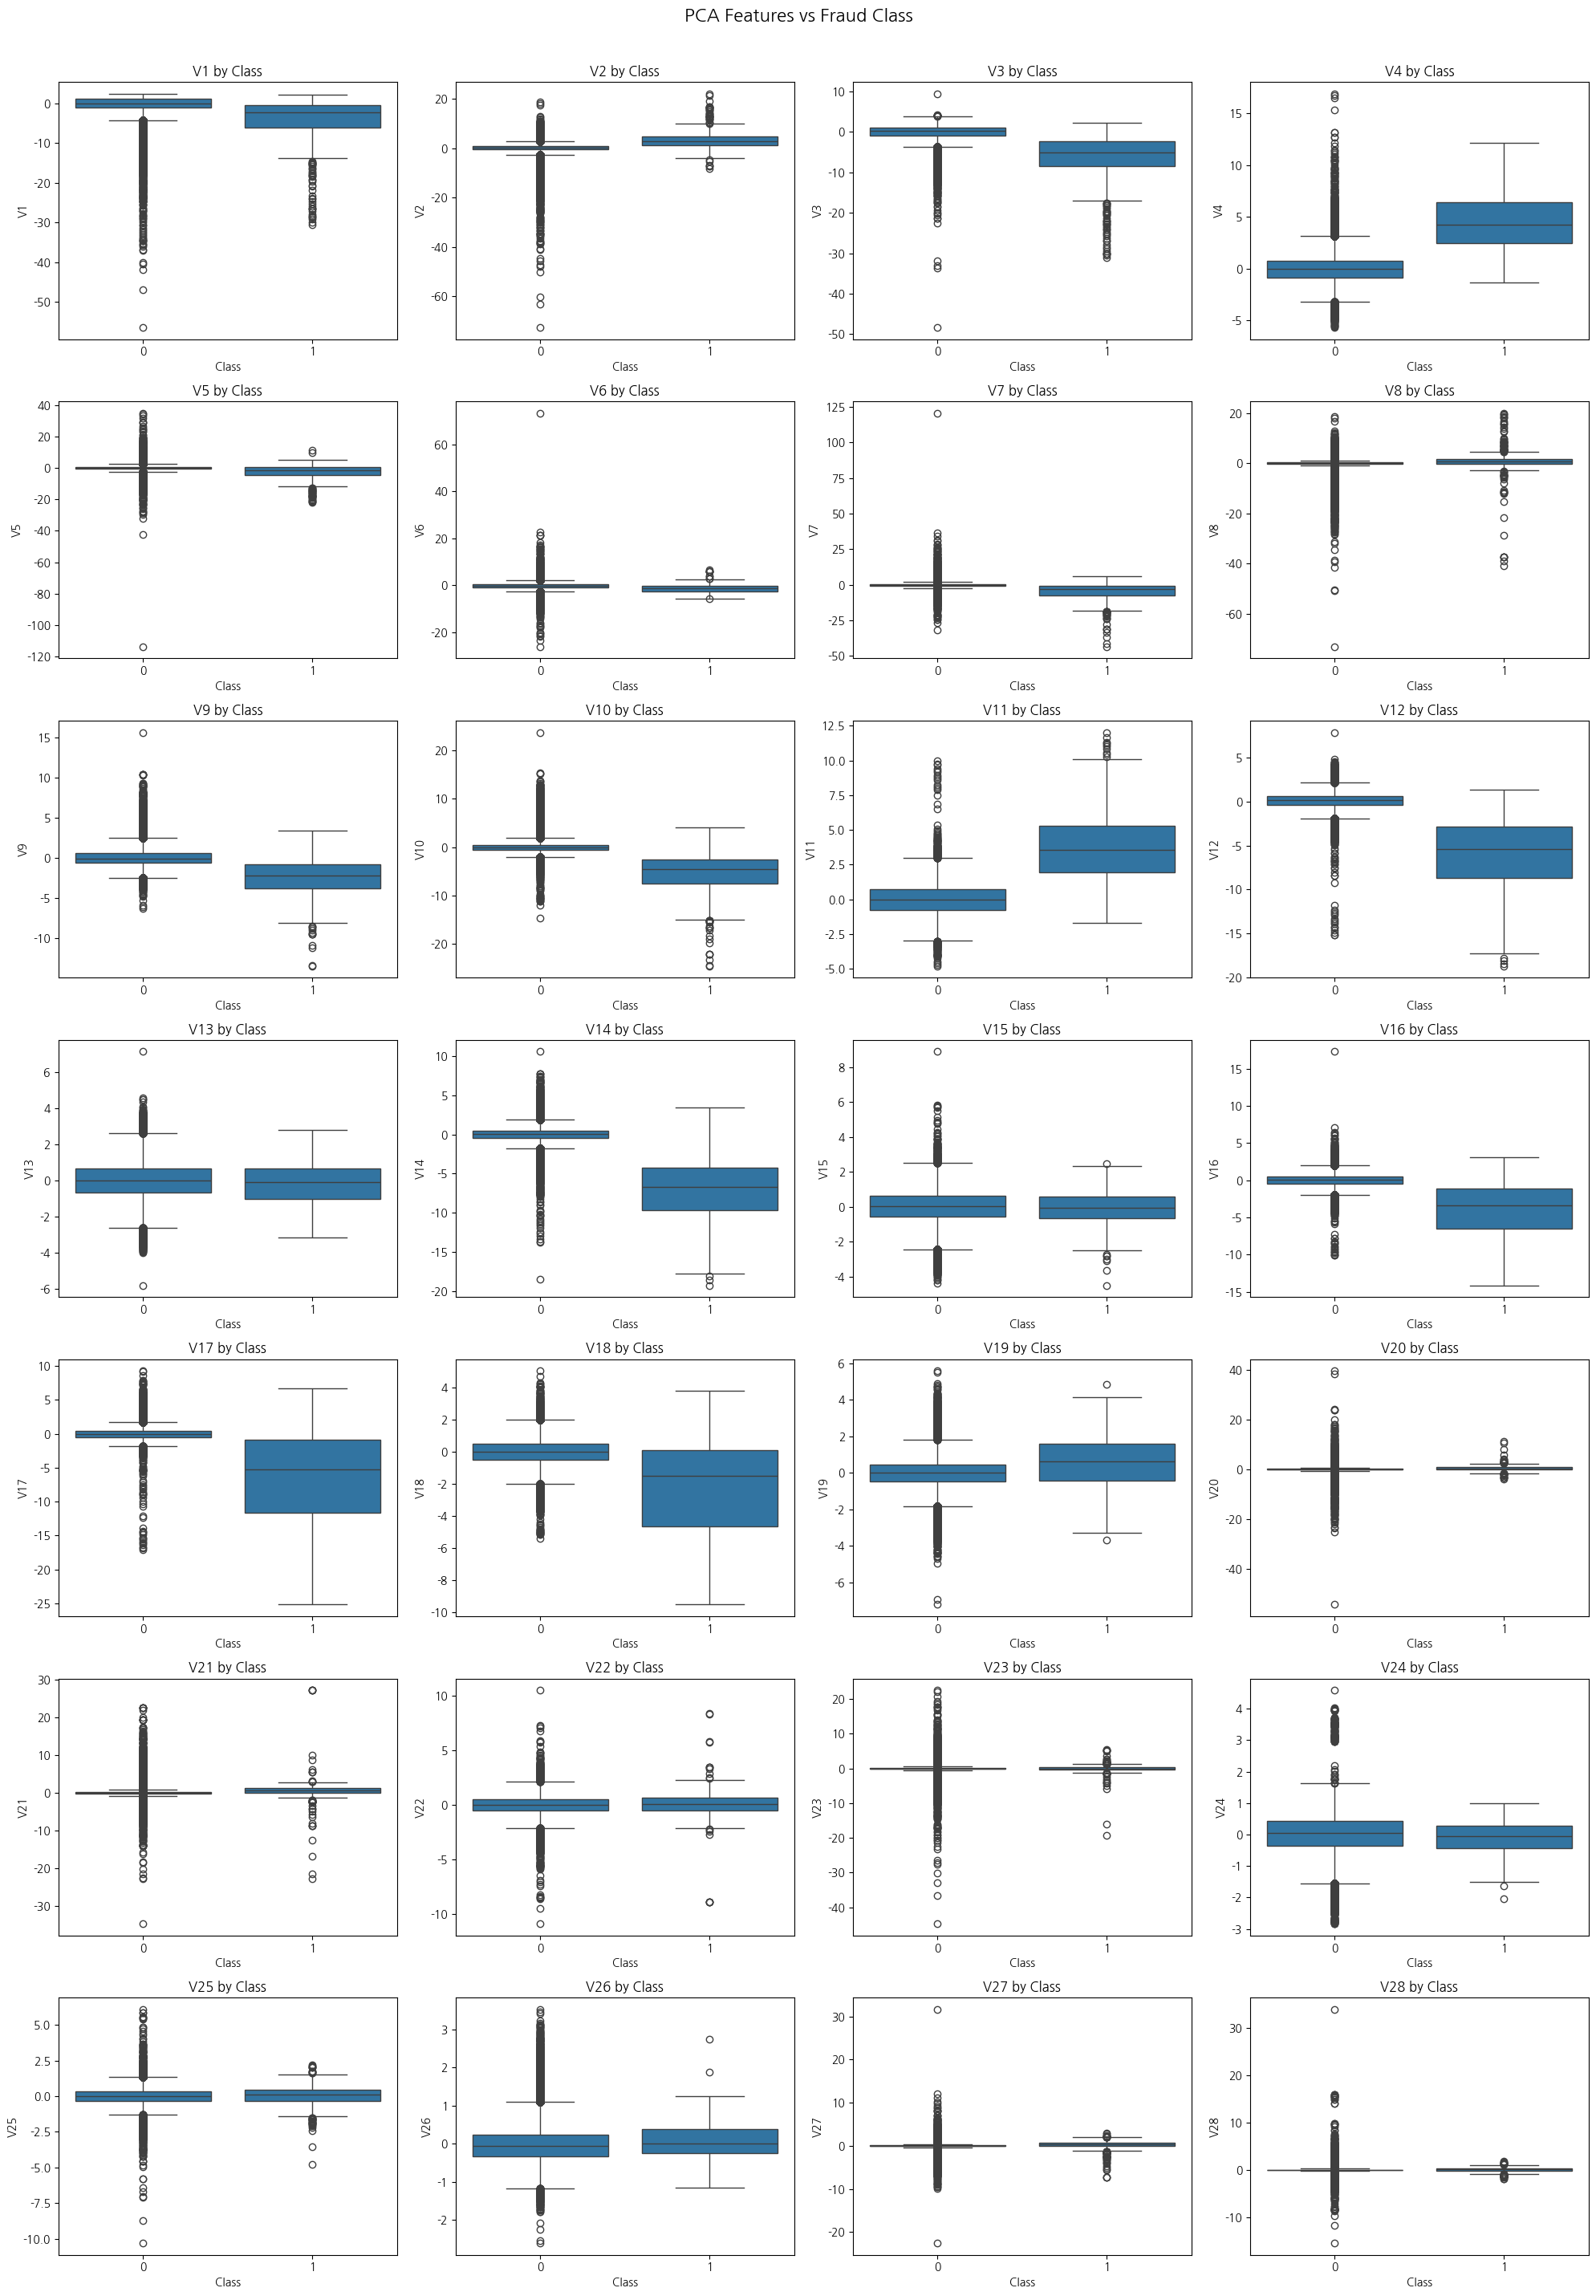

In [ ]:
# 분석 대상 특성들
pca_features = [f'V{i}' for i in range(1, 29)]

# 시각화 (boxplot)
n_cols = 4
n_rows = (len(pca_features) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(pca_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(data=train, x='Class', y=col)
    plt.title(f'{col} by Class')
    plt.xlabel('Class')
    plt.ylabel(col)

plt.tight_layout()
plt.suptitle('PCA Features vs Fraud Class', fontsize=16, y=1.02)
plt.savefig('pca features vs fraud class.png')
plt.show()

- 분포가 확실히 나뉜 변수들
  - V14: Class=1의 분포가 음수 쪽으로 명확히 치우침 -> 강력한 사기 신호
  - V17: 사기 거래일 때 명확히 낮은 값 ->  경계 구분이 잘됨
  - V12: 전체적으로 Class=1에서 중앙값이 낮고 분산도 작음
  - V10, V11: 중앙값과 분포 폭이 사기 거래와 정상 거래에서 분명히 다름
  - V4: 사기 거래에서 매우 높은 outlier 값 존재
- 거의 차이가 없는 변수들
  - V1, V2, V6, V13, V20, V22, V27
  - 모델 성능에 크게 기여하지 않을 가능성 높음

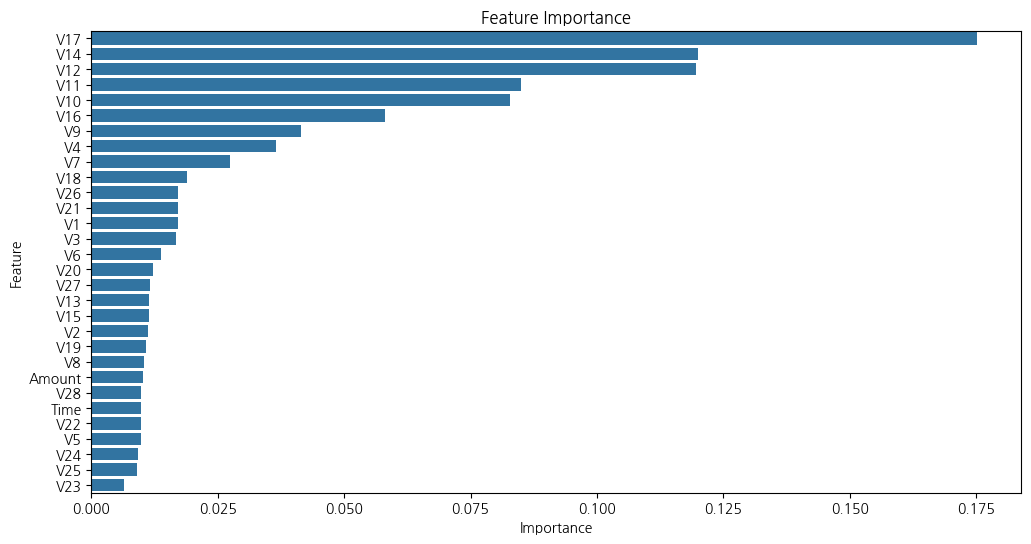

In [ ]:
# 해석 맞는지 확인용 (위에 왔다갔다 하기 귀찮이슈)
# feature importance
feature_names = X_train.columns # 변수 이름 리스트
importances = rf.feature_importances_ # 중요도 추출

# 데이터 프레임으로 정렬
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # 내림차순 정렬

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance')
plt.show()

- baseline model 본 피처 중요도에서 중요도가 높게 나온 피처들이 클래스별 분포가 확실히 나뉘는 것을 볼 수 있음

In [ ]:
# 각 변수별 이상치 개수 계산
# 이상치 계산 (4분위수로 해서 함)
pca_features = [f'V{i}' for i in range(1, 29)]

outlier_summary = {}

for col in pca_features:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outlier_count = ((train[col] < lower_bound) | (train[col] > upper_bound)).sum()
  outlier_summary[col] = outlier_count

# 데이터프레임으로 정리
outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns =['Outlier Count'])
outlier_df = outlier_df.sort_values('Outlier Count', ascending = False)
display(outlier_df)

,Outlier Count
V27,31263
V28,24270
V20,22235
V8,19202
V6,18260
V23,14818
V12,12171
V21,11525
V14,11293
V2,10778


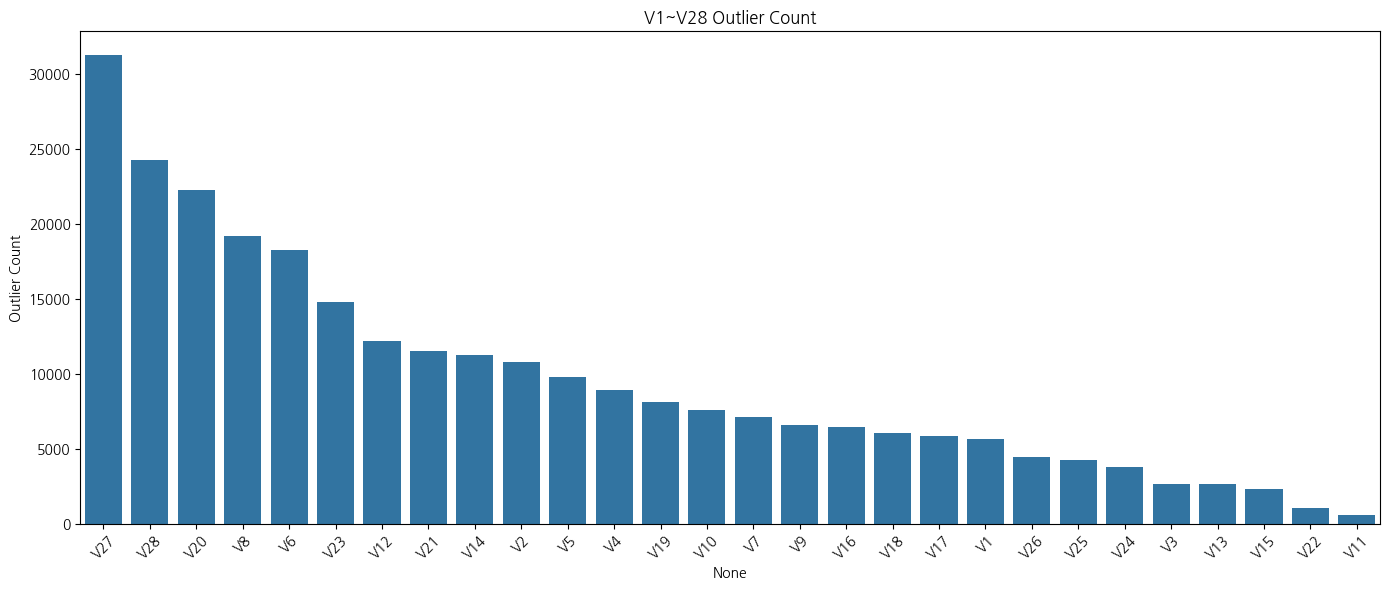

In [ ]:
# (V1~V28) 이상치 개수 시각화
plt.figure(figsize = (14, 6))
sns.barplot(data = outlier_df, x = outlier_df.index, y = 'Outlier Count')
plt.title('V1~V28 Outlier Count')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

- 이상치가 많이 나타나는 특성들
  - V27, V28, V20 등 -> 위에서 봤을 때 사기거래와 정상거래간 분포 차이가 거의 드러나지 않는 변수들
  - 이상치가 많다고 해서 사기거래에 크게 기여하는 패턴은 아님을 알 수 있음

- 이상치가 상대적으로 적은 특성들
  - V11: 피처 중요도가 높고 사기거래와 정상거래의 분포가 뚜렷하게 차이나는 변수
  - V22, V13, V3 등 -> 위에서 봤을 때 사기거래와 정상거래의 분포가 비슷한 변수

In [ ]:
# 클래스 분포가 차이나는 피처들의 이상치 개수
outlier_df['Outlier Count'][['V14', 'V17', 'V12', 'V10', 'V11', 'V4']].sort_values()

,Outlier Count
V11,605
V17,5867
V10,7575
V4,8920
V14,11293
V12,12171


- 혹시 위에서 찾은 클래스 분포가 뚜렷한 피처들의 이상치 개수가 비슷하거나 어떤 연관성이 있을까해서 봤지만 그런 점은 안보임

In [ ]:
# 이상치에 따른 사기거래 여부

# 이상치 여부 저장할 데이터프레임
outlier_flags = pd.DataFrame(index = df.index)

for col in outlier_df.index:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outlier_flags[col] = ((df[col] < lower_bound) | (df[col] > upper_bound))

In [ ]:
train['has_outlier'] = outlier_flags.any(axis=1).astype(int) # 하나라도 이상치면 1
train['num_outliers'] = outlier_flags.sum(axis=1) # 이상치 개수
train.head() # 확인

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,log_Amount,Hour,has_outlier,num_outliers
265518,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,...,-0.350316,-0.388907,0.077641,-0.032248,7.32,0,2.118662,44,1,2
180305,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,...,0.512885,-0.471198,0.002520,-0.069002,2.99,0,1.383791,34,1,2
42664,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,...,0.826684,0.913773,0.038049,0.185340,175.10,0,5.171052,11,1,3
198723,132624.0,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,...,-0.278032,-0.162068,0.018045,-0.063005,6.10,0,1.960095,36,0,0
82325,59359.0,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,...,-0.292234,-0.144622,-0.032580,-0.064194,86.10,0,4.467057,16,1,2


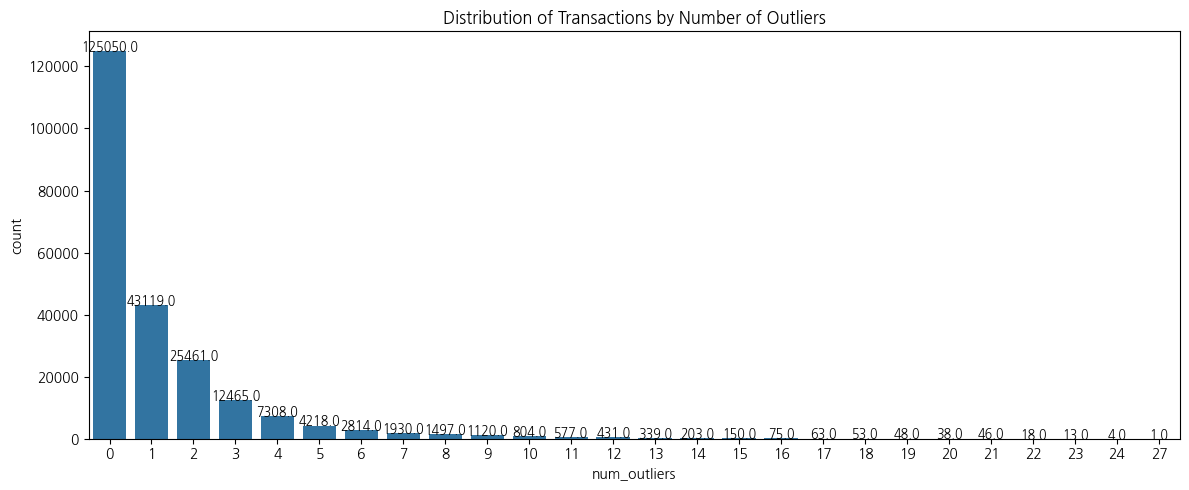

In [ ]:
# 이상치 개수별 거래 수
plt.figure(figsize=(12, 5))
sns.countplot(x='num_outliers', data=train)
plt.title('Distribution of Transactions by Number of Outliers')

# 거래 수 막대 위에 표시
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.text(p.get_x() + p.get_width() / 2., height + 50,
                 f'{height}', ha="center", fontsize=9)

plt.tight_layout()
plt.show()

- 대부분의 거래에서는 이상치가 적음

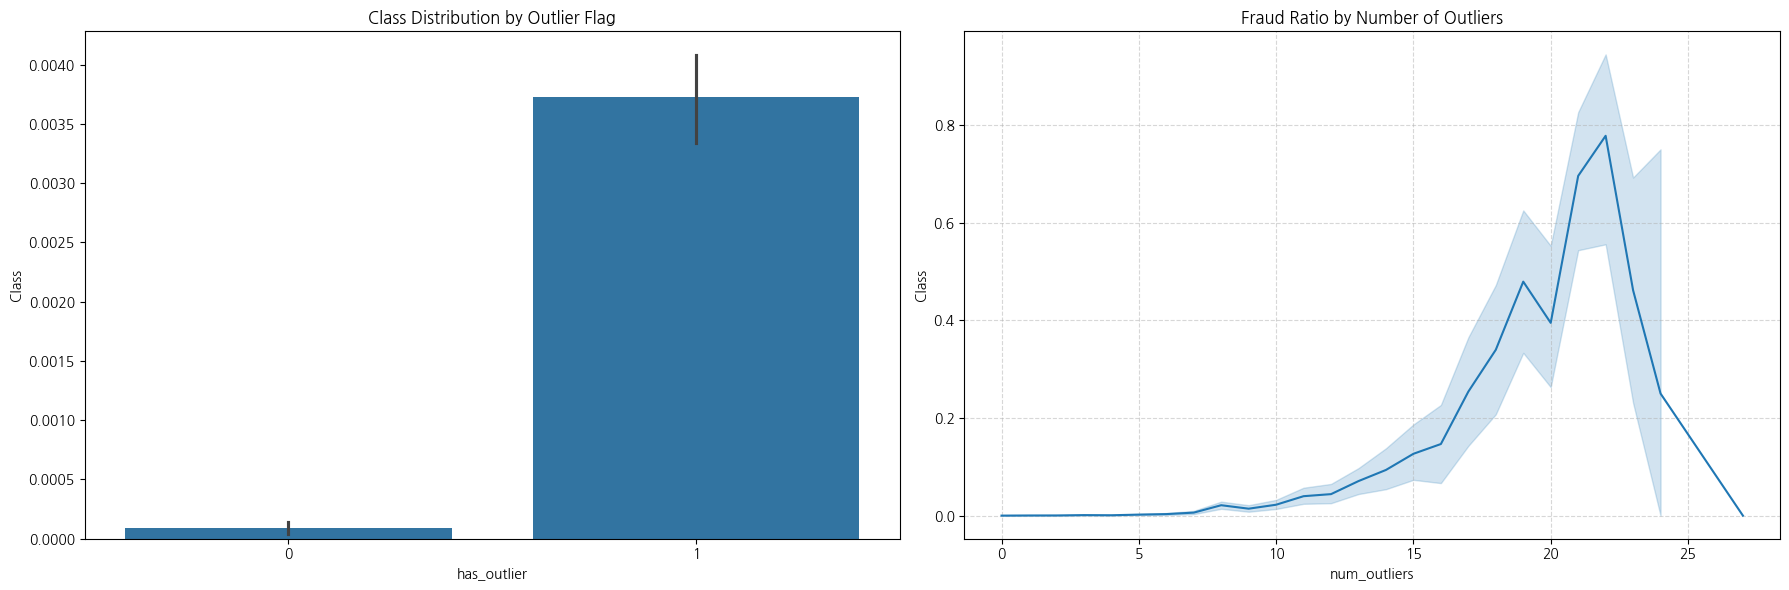

In [ ]:
# 시각화

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# 이상치 여부에 따른 클래스 분포
sns.barplot(x='has_outlier', y='Class', data=train, ax=axes[0])
axes[0].set_title('Class Distribution by Outlier Flag')

# 이상치 개수에 따른 사기거래 비율
sns.lineplot(x='num_outliers', y='Class', data=train, ax=axes[1])
axes[1].set_title('Fraud Ratio by Number of Outliers')
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- 사기거래는 정상거래에 비해 PCA 성분에서 이상치를 포함한 비율이 더 높음
- 이상치 개수가 많을수록 사기 거래 비율이 증가하는 경향을 보임
- 이상치 개수가 25개 이상인 거래에서는 사기거래가 감소함
  - 샘플 수가 적어서?
  - 이상치 개수와 사기거래는 상관이 없나?

In [ ]:
train.columns.tolist()

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class',
 'log_Amount',
 'Hour',
 'has_outlier',
 'num_outliers']

# 4. 데이터 전처리

In [ ]:
# eda용으로 추가했던 컬럼들
# eda_cols = ['Hour', 'log_Amount', 'has_outlier', 'num_outliers']

# train에서 해당 컬럼들 제거
# train = train.drop(columns = eda_cols)

# 다시 합쳐서 원본 df 형태로 복원
# df = pd.concat([train, test], axis=0).reset_index(drop=True)

# 복원 확인
# print(df.columns.tolist())

In [ ]:
# 데이터셋 불러오기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기계학습/creditcard.csv')

In [ ]:
# 나언 코드 반영
# Time, Amount 스케일링
df['Hour'] = (df['Time'] // 3600).astype(int)
df['Hour_mod'] = df['Hour'] % 24
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour_mod'] / 24)

scaler = StandardScaler()
df['Hour_sin'] = scaler.fit_transform(df[['Hour_sin']])

#이상치인 경우 class1 비율이 높으므로 이러한 특성을 남겨 두기 위해 StandardScaler 사용
df['Amount'] = np.log1p(df['Amount'])
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,Hour,Hour_mod,Hour_sin
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.124303,0,0,0,0.375742
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.339846,0.167170,0.125895,-0.008983,0.014724,-1.114639,0,0,0,0.375742
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.682368,0,0,0,0.375742
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.009339,0,0,0,0.375742
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670241,0,0,0,0.375742


In [ ]:
# train/ test 나누기
X = df.drop(columns=['Class', 'Hour', 'Hour_mod'], inplace=False)
y = df['Class']

# 훈련셋, 테스트셋 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from imblearn.over_sampling import SMOTE
# 오버샘플링
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print(df.columns)
print(X_train.columns)
print(X_test.columns)
print(y_train.shape)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Hour', 'Hour_mod', 'Hour_sin'],
      dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Hour_sin'],
      dtype='object')
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Hour_sin'],
      dtype='object')
(227845,)


In [ ]:
# 오버샘플링 확인
print(y_train_resampled.value_counts())

Class
0    227451
1    227451
Name: count, dtype: int64


- 기존 400개 정도이던 클래스 1의 비율을 22만개까지 늘려서 1:1 비율로 맞춤
- 이에 따른 문제점: 과적합 가능성

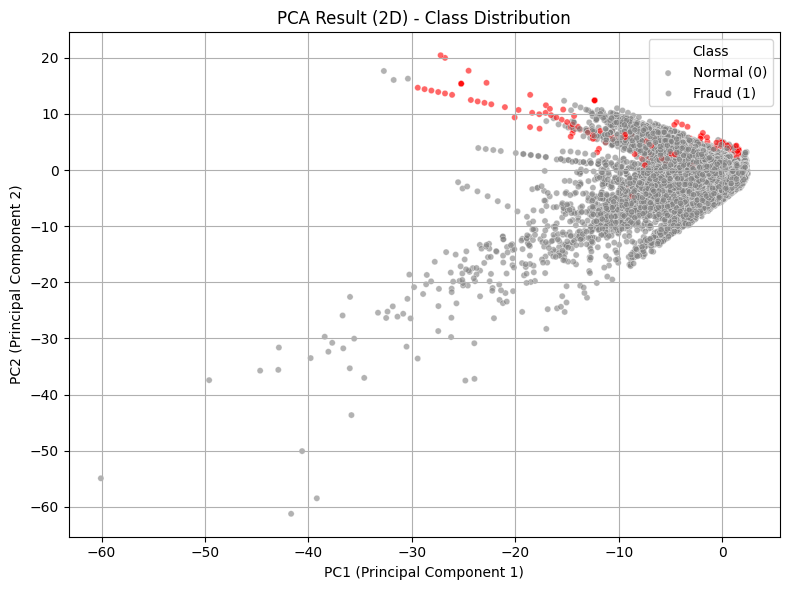

In [ ]:
features_num = [f'V{i}' for i in range(1,29)] + ['Amount', 'Hour_sin']
X_scaled = X_train[features_num]

from sklearn.decomposition import PCA
pca = PCA(n_components=0.95, random_state=42)
X_pca95 = pca.fit_transform(X_scaled)

pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1": X_pca95[:, 0],
    "PC2": X_pca95[:, 1],
    "Class": y_train.values
})

# 2) 시각화
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="Class",
    palette={0: "gray", 1: "red"},  # 클래스 1을 빨간색으로
    alpha=0.6,
    s=20
)
plt.title("PCA Result (2D) - Class Distribution")
plt.xlabel("PC1 (Principal Component 1)")
plt.ylabel("PC2 (Principal Component 2)")
plt.legend(title="Class", labels=["Normal (0)", "Fraud (1)"])
plt.grid(True)
plt.tight_layout()
plt.show()

- 기존 V1~V28, Amount, Time 피처에 Amount 와 Time 피처를 스케일링 한 후 pca로 차원 줄인 후 클래스 분포를 시각화
- 30차원 -> 2차원으로, 2차원 피처는 기존 클래스 분포를 가장 잘 설명하는 2개의 축으로 나타내었다. 하지만 데이터 불균형이 심하고 매우 큰 차원에서 작은 차원으로 줄였기 때문에 정상 케이스와 사기 케이스 간의 분리가 잘 설명되지 않음을 볼 수 있다.

# 5. 모델 학습

In [ ]:
# 결과 출력 함수
def print_result(model, name):
    print(f"\n{'-'*20} {name} {'-'*20}\n")
    # 예측 및 평가
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1] # Class=1 일 확률만 추출

    # 정밀도-재현율 곡선(PR) 계산
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    # AURPRC 계산
    auc_rc = auc(recall, precision)

    print('Classfication Report: \n', classification_report(y_test, y_pred))
    print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
    print('AUPRC (Area Under PR Curve):', round(auc_rc, 4))

    # PR 곡선 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

## 베이스라인 모델
- 스케일링, 오버샘플링 하고 난 후


-------------------- Logistic Regression(L1) --------------------

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.12      0.90      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962

Confusion Matrix: 
 [[56248   616]
 [   10    88]]
AUPRC (Area Under PR Curve): 0.7822


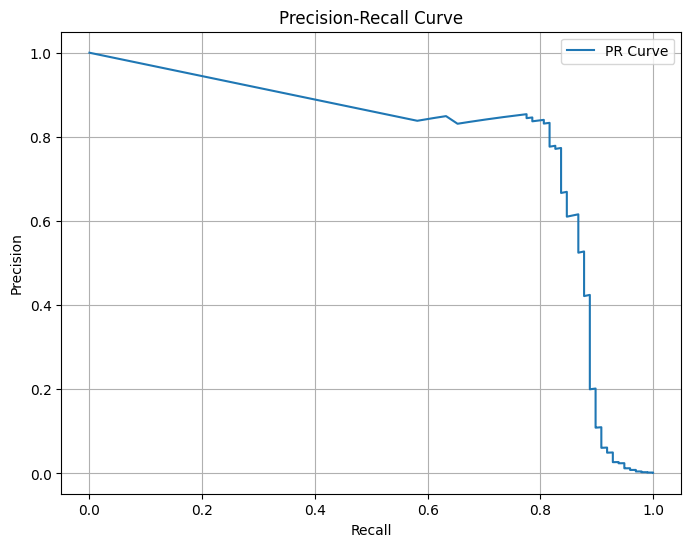

In [ ]:
# 로지스틱 회귀 - L1
lr = LogisticRegression(
    penalty='l1',
    C=1.0,                    # 규제 강도: 작을수록 규제 강해짐
    class_weight='balanced',  # 소수 클래스(사기)에 더 높은 패널티
    solver='liblinear',           # L1도 함께 테스트하면 'liblinear' or 'saga'
    random_state=42,
    max_iter=500,
)

# 모델 학습
lr.fit(X_train_resampled, y_train_resampled)

# 결과 출력
print_result(lr, 'Logistic Regression(L1)')


-------------------- Logistic Regression(L2) --------------------

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.90      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962

Confusion Matrix: 
 [[56130   734]
 [   10    88]]
AUPRC (Area Under PR Curve): 0.7171


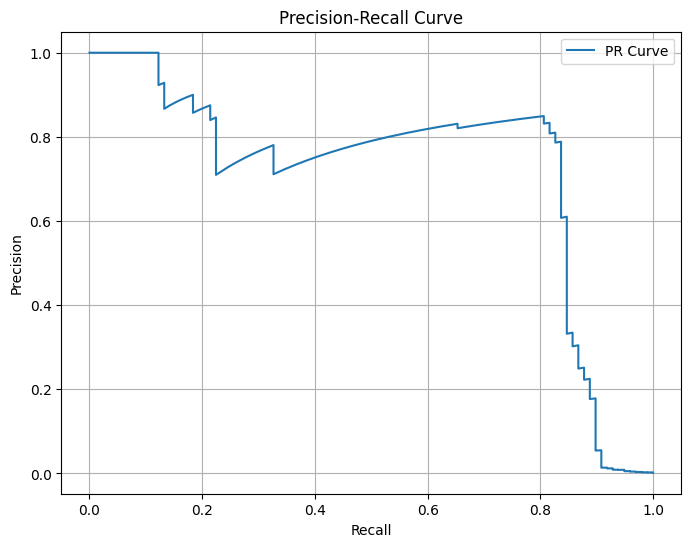

In [ ]:
# 로지스틱 회귀 - L2
# 나언 코드 반영해서 규제, 파라미터 똑같이 반영
lr = LogisticRegression(
    penalty='l2',
    C=1.0,                    # 규제 강도: 작을수록 규제 강해짐
    class_weight='balanced',
    solver='liblinear',           # L1도 함께 테스트하면 'liblinear' or 'saga'
    random_state=42,
    max_iter=500,
)
# 모델 학습
lr.fit(X_train_resampled, y_train_resampled)

# 결과 출력
print_result(lr, 'Logistic Regression(L2)')


-------------------- DecisionTreeClassifier(gini) --------------------

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.89      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.58     56962
weighted avg       1.00      0.98      0.99     56962

Confusion Matrix: 
 [[55970   894]
 [   11    87]]
AUPRC (Area Under PR Curve): 0.5145


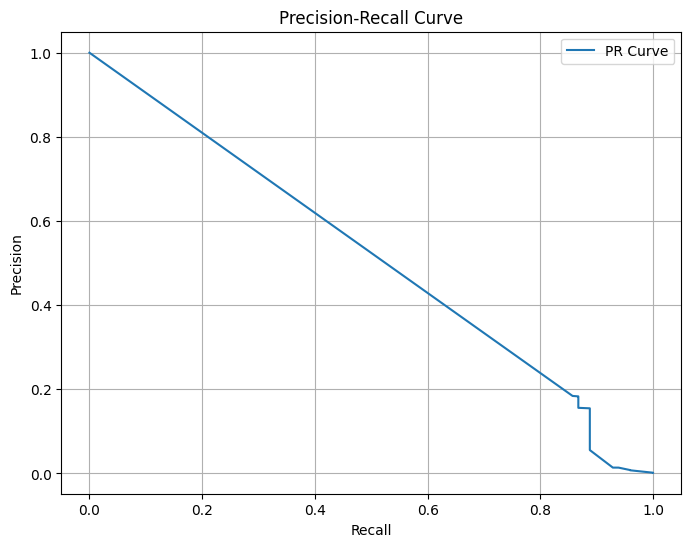

In [ ]:
# DecisonTree - Gini
dt = DecisionTreeClassifier(
    criterion='gini',
    random_state=42,
    max_depth=4
  )

# 모델 학습
dt.fit(X_train_resampled, y_train_resampled)

# 결과 출력
print_result(dt, 'DecisionTreeClassifier(gini)')


-------------------- DecisionTreeClassifier(entropy) --------------------

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.89      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Confusion Matrix: 
 [[55542  1322]
 [   11    87]]
AUPRC (Area Under PR Curve): 0.7335


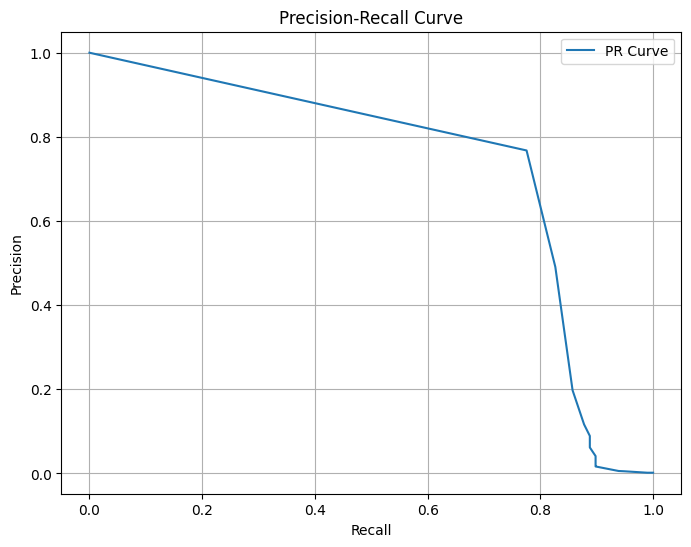

In [ ]:
# DecisonTree - Entropy
dt = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=4
  )

# 모델 학습
dt.fit(X_train_resampled, y_train_resampled)

# 결과 출력
print_result(dt, 'DecisionTreeClassifier(entropy)')

- 스케일링&오버샘플링 하기 전과 다르게 분할 조건이 엔트로피인 경우가 더 성능이 좋음
- 결정나무는 스케일링에 영향을 받는 모델이 아니므로 오버샘플링을 통해 클래스의 분포가 바뀐 것이 이유
- 지니계수로 하면 대부분을 다 정상으로 분류해도 불순도가 크게 낮아짐
- 반면 엔트로피는 더 민감하게 적용


-------------------- KNN --------------------

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.73      0.13        98

    accuracy                           0.98     56962
   macro avg       0.53      0.86      0.56     56962
weighted avg       1.00      0.98      0.99     56962

Confusion Matrix: 
 [[55904   960]
 [   26    72]]
AUPRC (Area Under PR Curve): 0.4593


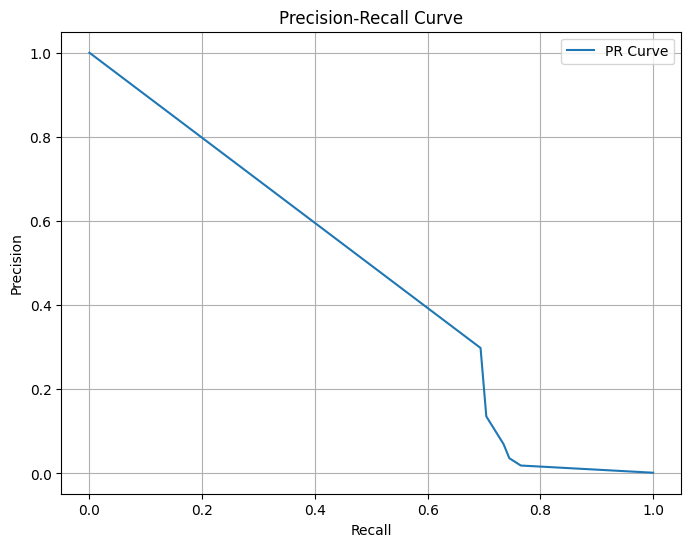

In [ ]:
# KNN
knn = KNeighborsClassifier(
    n_neighbors=5,
    p=2,
    metric='minkowski'
)

# 모델 학습
knn.fit(X_train_resampled, y_train_resampled)

# 결과 출력
print_result(knn, 'KNN')

- 스케일링을 하기 전에 비해 성능 오름

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")



-------------------- MLPClassifier --------------------

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.98     56962

Confusion Matrix: 
 [[55335  1529]
 [    9    89]]
AUPRC (Area Under PR Curve): 0.5063


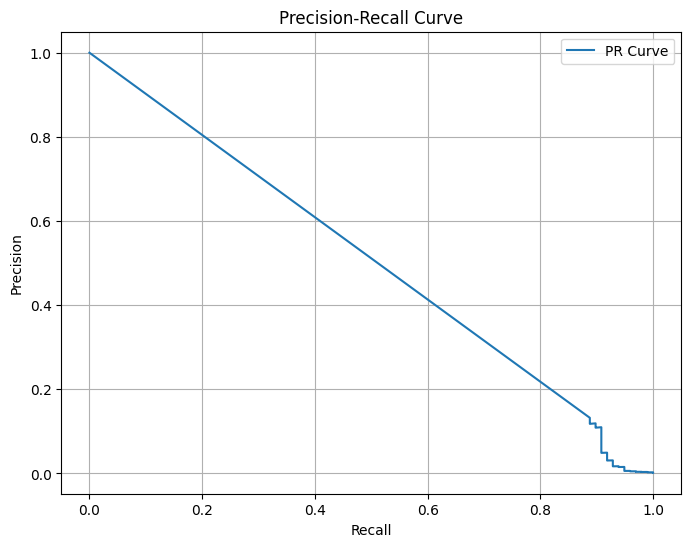

In [ ]:
# MLPClassifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),   # 은닉층 구조: 예시로 히든 노드 100개짜리 한 층
    activation='relu',           # 활성화 함수 (ReLU)
    solver='adam',               # 최적화 알고리즘 (Adam)
    alpha=0.0001,                # L2 정규화 (weight_decay)
    learning_rate='adaptive',    # 학습률 조정 방식
    max_iter=200,                # 최대 반복(epoch) 수
    random_state=42,
    early_stopping=True,    # 개선 없으면 자동으로 멈춤
)
mlp.fit(X_train_resampled, y_train_resampled)

# 결과 출력
print_result(mlp, 'MLPClassifier')

### Best Model: LogisticRegression (L1)

## Advanced Model

In [ ]:
# 앙상블 - VotingClassifier: 위의 baseline model 중 성능이 좋았던 3개의 모델로 진행 - LogisticRegression, DecisonTree(Entropy), MLPClassifier
# 위에서 사용했던 모델들
'''
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),   # 은닉층 구조: 예시로 히든 노드 100개짜리 한 층
    activation='relu',           # 활성화 함수 (ReLU)
    solver='adam',               # 최적화 알고리즘 (Adam)
    alpha=0.0001,                # L2 정규화 (weight_decay)
    learning_rate='adaptive',    # 학습률 조정 방식
    max_iter=200,                # 최대 반복(epoch) 수
    random_state=42
)
'''

# 로지스틱 회귀 - L1
lr = LogisticRegression(
    penalty='l1',
    C=1.0,                    # 규제 강도: 작을수록 규제 강해짐
    class_weight='balanced',  # 소수 클래스(사기)에 더 높은 패널티
    solver='liblinear',           # L1도 함께 테스트하면 'liblinear' or 'saga' -> 확률적 경사하강법 너무 오래걸려서 'liblinear'로 했어요
    random_state=42,
    max_iter=500,
)
dt = DecisionTreeClassifier(criterion='entropy',random_state=42, max_depth=4) # 엔트로피 트리
# knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski') # 성능 안좋고 시간도 오래걸려서 제외함


-------------------- VotingClassifier(soft) --------------------

Classfication Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.23        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962

Confusion Matrix: 
 [[56269   595]
 [   10    88]]
AUPRC (Area Under PR Curve): 0.7574


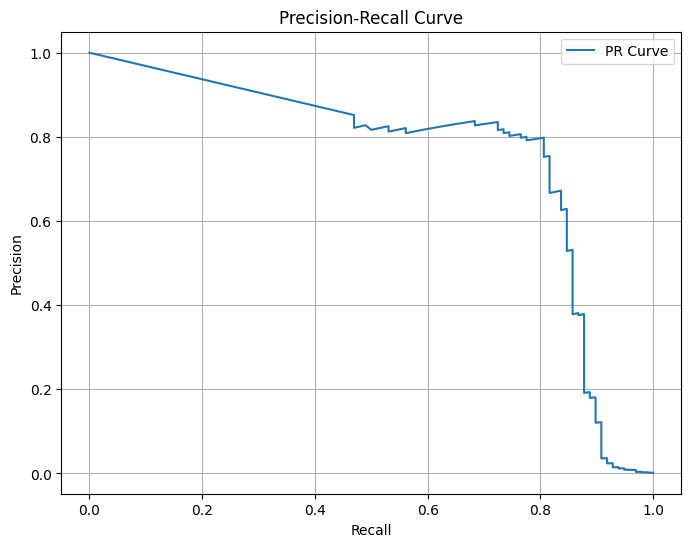

In [ ]:
model = [('lr', lr), ('dt', dt), ('mlp', mlp)]
# 투표방식: soft
voting_soft = VotingClassifier(
    estimators=model,
    weights=[3, 2, 1],      # L1 로지스틱 비중 크게, 결정나무·MLP 순
    voting='soft',
    n_jobs=-1
)

# 투표방식: hard
voting_hard = VotingClassifier(
    estimators=model, #('knn', knn)
    voting='hard',
    n_jobs=-1
)

# 모델 학습
voting_soft.fit(X_train_resampled, y_train_resampled)
voting_hard.fit(X_train_resampled, y_train_resampled)

print_result(voting_soft, 'VotingClassifier(soft)')

# print_result(voting_hard, 'VotingClassifier(hard)') 하드 보팅은 확률이 없으므로 분류 성능만 확인

-

In [ ]:
y_pred_hard = voting_hard.predict(X_test)
print("Hard Voting Report:\n", classification_report(y_test, y_pred_hard))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_hard))

Hard Voting Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.90      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962

Confusion Matrix:
 [[56254   610]
 [   10    88]]


Classfication Report: 
               precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8454    0.8367    0.8410        98

    accuracy                         0.9995     56962
   macro avg     0.9225    0.9182    0.9204     56962
weighted avg     0.9995    0.9995    0.9995     56962

Confusion Matrix: 
 [[56849    15]
 [   16    82]]
AUPRC (Area Under PR Curve): 0.8702


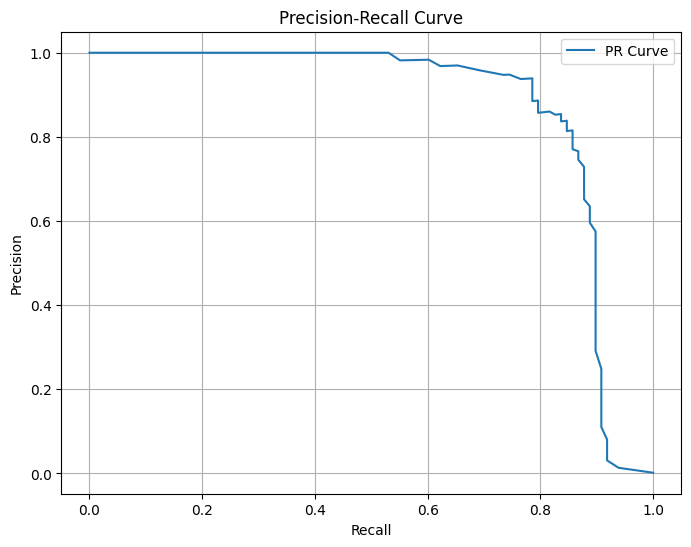

In [ ]:
# 랜덤포레스트
rf = RandomForestClassifier(
    criterion='entropy',
    random_state = 42,
    n_estimators=100,
    n_jobs=-1,
    class_weight="balanced")

# 모델학습
rf.fit(X_train_resampled, y_train_resampled)

# 결과 출력
print_result(rf, 'RandomForest')

- 오버샘플링&스케일링 하기 전 모델과 비교했을 때 성능 향상!

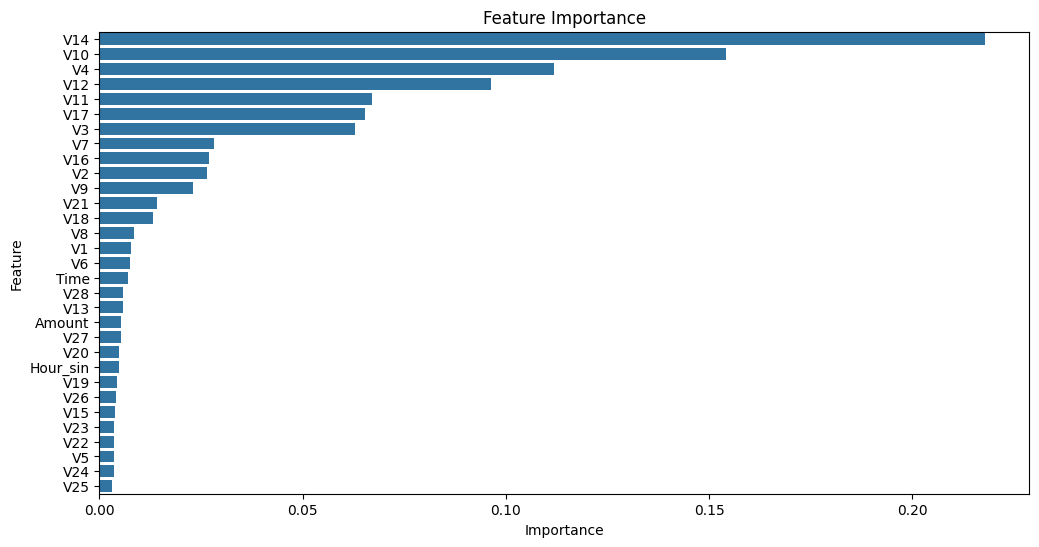

In [ ]:
# Feature Importance
# 원래 사용한 피처 이름 리스트 재정의
features = ['Time'] + [f'V{i}' for i in range(1, 29)] + ['Amount'] + ['Hour_sin']
feature_names = features

importances = rf.feature_importances_ # 중요도 추출

# 데이터 프레임으로 정렬
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # 내림차순 정렬

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance')
plt.show()

스케일링&오버샘플링 이후에는,
- V14의 피처 중요도가 가장 높아짐 (이전과 다른결과)

Classfication Report: 
               precision    recall  f1-score   support

           0     0.9998    0.9782    0.9889     56864
           1     0.0664    0.8980    0.1237        98

    accuracy                         0.9781     56962
   macro avg     0.5331    0.9381    0.5563     56962
weighted avg     0.9982    0.9781    0.9874     56962

Confusion Matrix: 
 [[55627  1237]
 [   10    88]]
AUPRC (Area Under PR Curve): 0.772


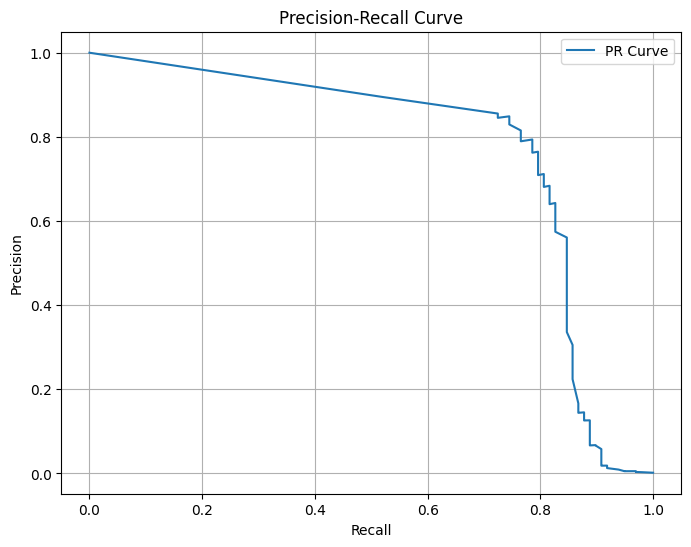

In [ ]:
# Bagging
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(  # 기본 추정기로 결정 트리 사용
        criterion='entropy',           # 정보 이득(Entropy) 기준으로 분할
        random_state=42,               # 재현성을 위한 랜덤 시드 고정
        max_depth=4                    # 트리 최대 깊이 제한으로 과적합 방지
    ),
    n_estimators=100,                  # 앙상블에 사용할 트리(추정기) 개수
    random_state=42,                   # 부트스트랩 샘플링 시드 고정
    max_samples=0.5,                   # 각 트리 학습에 사용될 훈련 샘플 비율 (50%)
    n_jobs=-1,                         # 모든 CPU 코어를 사용하여 병렬 학습
    bootstrap=True                     # 복원 추출 방식(중복 허용)으로 샘플링
)

# 모델학습
bag.fit(X_train_resampled, y_train_resampled)

# 결과출력
print_result(bag, 'Bagging')

Classfication Report: 
               precision    recall  f1-score   support

           0     0.9997    0.9981    0.9989     56864
           1     0.4233    0.8163    0.5575        98

    accuracy                         0.9978     56962
   macro avg     0.7115    0.9072    0.7782     56962
weighted avg     0.9987    0.9978    0.9981     56962

Confusion Matrix: 
 [[56755   109]
 [   18    80]]
AUPRC (Area Under PR Curve): 0.62


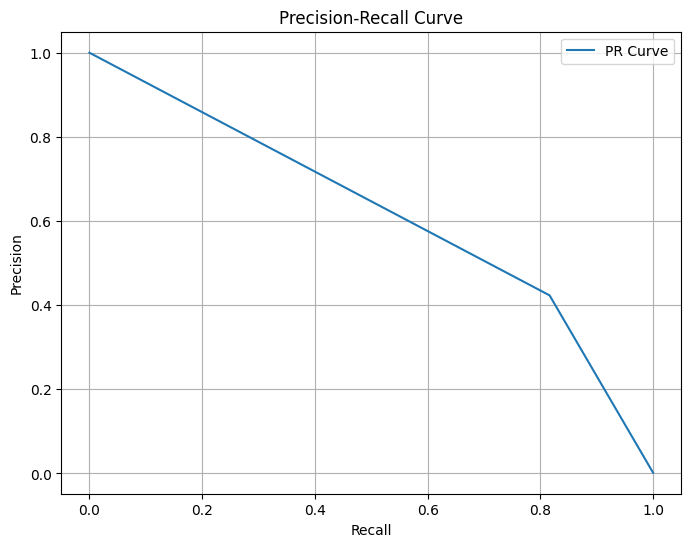

In [ ]:
# AdaBoost
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

# 모델 학습
ada.fit(X_train_resampled, y_train_resampled)

# 결과출력
print_result(ada, 'AdaBoostClassifier')

- Best Model:Random Forest

# 6. 성능개선 & 결론
- Best Model 중심으로 성능개선
- 사기거래일수록 이상치가 많다는 것이 확인되었기 때문에 이상치를 무작정 제거할 순 없음
- 오버샘플링 비율 조절(기존 모델에선 1:1 비율), 불필요한 피처 제거

In [ ]:
# 나언 코드 참고
smote = SMOTE(sampling_strategy=0.1,random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 오버샘플링 확인
print("Resampled X shape:", X_train_resampled.shape)
print("Resampled y shape:", y_train_resampled.shape)
print("Resampled y Series name:", y_train_resampled.name)      # Series 이름 확인
print("Resampled y index (일부):", y_train_resampled.index[:5])  # 인덱스 일부 샘플

Resampled X shape: (250196, 31)
Resampled y shape: (250196,)
Resampled y Series name: Class
Resampled y index (일부): RangeIndex(start=0, stop=5, step=1)


Classfication Report: 
               precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998     56864
           1     0.8571    0.8571    0.8571        98

    accuracy                         0.9995     56962
   macro avg     0.9284    0.9284    0.9284     56962
weighted avg     0.9995    0.9995    0.9995     56962

Confusion Matrix: 
 [[56850    14]
 [   14    84]]
AUPRC (Area Under PR Curve): 0.8807


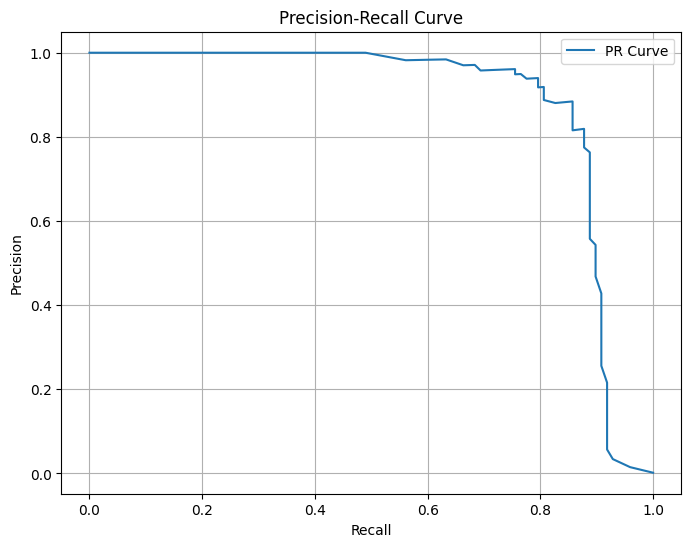

In [ ]:
# ver1. 오버샘플링 비율만 변경
# 랜덤포레스트
rf_ver1 = RandomForestClassifier(random_state = 42,
                                 n_estimators=100,
                                 n_jobs=-1,
                                 class_weight="balanced"
)

rf.fit(X_train_resampled, y_train_resampled)

# 결과 출력
print_result(rf_ver1, 'RandomForest-Evaluation_ver1')

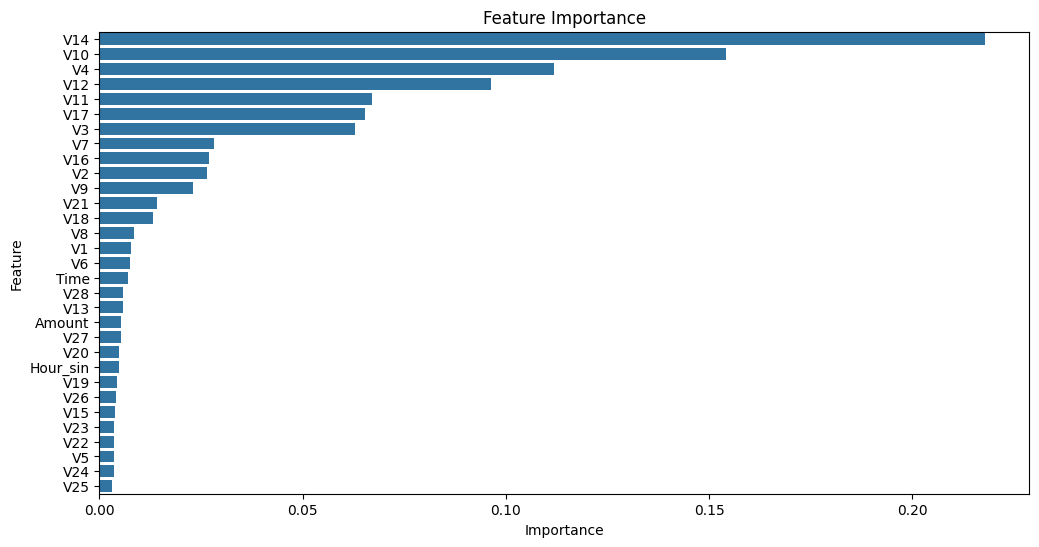

In [ ]:
# Feature Importance
# 원래 사용한 피처 이름 리스트 재정의
features = ['Time'] + [f'V{i}' for i in range(1, 29)] + ['Amount'] + ['Hour_sin']
feature_names = features

importances = rf_ver1.feature_importances_ # 중요도 추출

# 데이터 프레임으로 정렬
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # 내림차순 정렬

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance')
plt.show()

Classfication Report: 
               precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8495    0.8061    0.8272        98

    accuracy                         0.9994     56962
   macro avg     0.9246    0.9029    0.9135     56962
weighted avg     0.9994    0.9994    0.9994     56962

Confusion Matrix: 
 [[56850    14]
 [   19    79]]
AUPRC (Area Under PR Curve): 0.8576


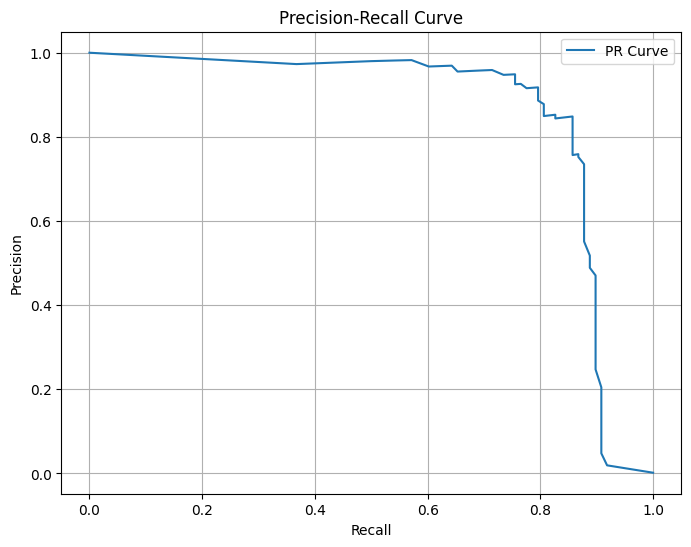

In [ ]:
# ver2. 오버샘플링 비율 변경 + 중요도 낮은 피처 상위 6개 제외하고 학습 진행
# 중요도가 낮아 보이는 피처 리스트(예: V23, V25, V24, V5, V22, V8, V19, V2, V15, V13, V27, V20, V6, V3) 정의
drop_cols = [
    "V23", "V25", "V24", "V5", "V22", "V8" #
]

# 4) 불필요한 컬럼 드롭
X_reduced = X_train_resampled.drop(columns=drop_cols)
X_reduced_test = X_test.drop(columns=drop_cols)

# BestModel: RandomForest로 학습 진행
rf_ver2 = RandomForestClassifier(random_state = 42,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

# 모델학습
rf.fit(X_reduced, y_train_resampled)

# 결과출력
print_result(rf_ver2, 'RandomForest-Evaluation_ver2')